In [1]:
import os
import datetime
from tqdm import tqdm

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from skimage.feature import blob_log

from models.TransUnet.TransUnet import TransUnet
from models.TransUnet.trainer import train
from models.TransUnet.config import get_config
from datasets.datasets import Dataset_TEMImageNet, preprocessing_label, preprocessing_image
from utils.utils import load_dm3, denoise

config = get_config()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [2]:
# TEMImageNet
dataset = Dataset_TEMImageNet('circularMask', num_classes=2)
# 计算划分的样本数量
ratio = 0.9
train_size = int(ratio * len(dataset))
valtest_size = len(dataset) - train_size
val_size = int(ratio * valtest_size)
test_size = valtest_size - val_size

# 使用 random_split 函数划分数据集
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(14128))
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=16, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

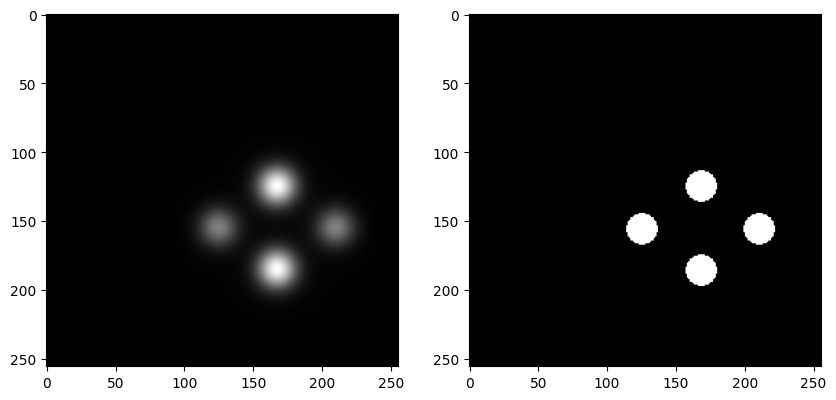

In [3]:
image, label = dataset[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(label[1], cmap='gray')
plt.show()

In [4]:
# 定义参数
epochs = 100
weight_decay = 0.0005
learning_rate_list =[0.001]
loss_type = ['CrossEntropyLoss', 'ModifiedMSE'][0]

In [ ]:
# 模型训练
for learning_rate in learning_rate_list:
    model = TransUnet(config, img_size=256, num_classes=2)
    model.load_from(weights=np.load(config.pretrained_path))
    info = 'denoise'
    current_time = datetime.datetime.now()
    current_time = datetime.datetime.strftime(current_time, r'%Y%m%d-%H%M%S')
    save_path = os.path.join('results', f'TransUnet_{current_time}_lr={learning_rate}_wd={weight_decay}_{info}')
    train(model, device, save_path, train_dataloader, learning_rate, weight_decay, epochs, loss_type)